In [1]:
from BSTools_pennylane import *
from matplotlib import pyplot as plt
from matplotlib import cm

In [2]:
# PDE parameters
sigma = 0.2
r = 0.3
Smax = 135
K = 50
T = 1

# Simulation parameters
n = 6 # Number of qubits
N = 2**n


instance = BS(r,K,Smax)

In [3]:
def Ngates(circuit, args):
    dict_op = qml.specs(circuit)(*args)["resources"].gate_types
    count = 0
    for op,num in dict_op.items():
        # print(op)
        if 'CNOT' in op:
            count+=num
    return count

def L2_rel(a,b):
    return np.linalg.norm(a-b)**2/np.linalg.norm(b)**2

fontsize=12

4
5
6
7
8
9


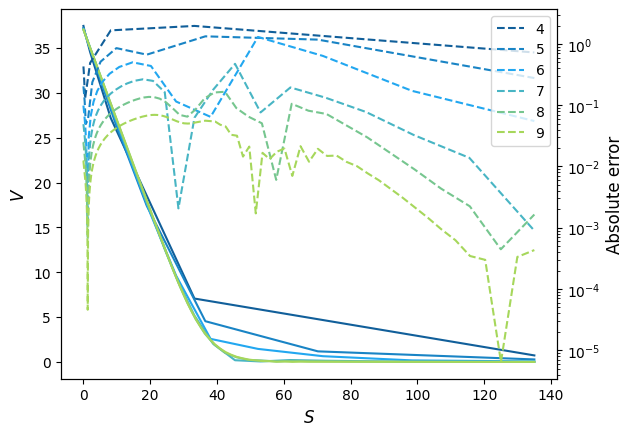

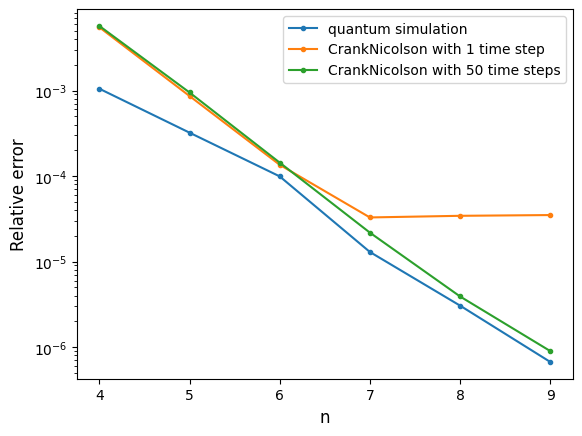

In [4]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
color = ["#115f9a", "#1984c5", "#22a7f0", "#48b5c4", "#76c68f", "#a6d75b", "#c9e52f", "#d0ee11", "#d0f400"]

instance = BS(r,K,Smax)
n_vec = np.arange(4,10)
err_rel = np.zeros((4,len(n_vec)))

for i,n in enumerate(n_vec):
    print(n)
    
    V = instance.solve("QC", n, sigma, T)
    x = instance.x
    exactp = instance.solve("exactp", n, sigma, T)
    exact = instance.solve("exact", n, sigma, T)
    
    CN1 = instance.solve("CN", n, sigma, T, Nt=2)[2**(n-1):]
    CN50 = instance.solve("CN", n, sigma, T, Nt=51)[2**(n-1):]
    
    err_rel[0,i] = L2_rel(V,exact)
    err_rel[1,i] = L2_rel(V,exactp)
    err_rel[2,i] = L2_rel(CN1,exactp)
    err_rel[3,i] = L2_rel(CN50,exactp)
    
    ax1.plot(np.exp(x),V, '-',color=color[i])
    ax2.plot(np.exp(x), np.abs(V-exact), '--',color=color[i])
ax2.set_yscale('log')
ax1.set_ylabel(r"$V$", fontsize=fontsize)
ax2.set_ylabel("Absolute error", fontsize=fontsize)
ax1.set_xlabel(r"$S$", fontsize=fontsize)
plt.legend(n_vec, loc='upper right')
plt.show()

plt.plot(n_vec, err_rel[0,:], '.-')
# plt.plot(n_vec, err_rel[1,:])
plt.plot(n_vec, err_rel[2,:], '.-')
plt.plot(n_vec, err_rel[3,:], '.-')
plt.yscale('log')
plt.ylabel('Relative error',fontsize=fontsize)
plt.xlabel('n',fontsize=fontsize)
plt.legend(['quantum simulation','CrankNicolson with 1 time step', 'CrankNicolson with 50 time steps'])
plt.show()

4
5
6
7
8


/home/hjaunin/.local/lib/python3.9/site-packages/python_tsp/heuristics/simulated_annealing.py:187: RuntimeWarning: divide by zero encountered in scalar divide
  (dfx > 0) and (np.random.rand() <= np.exp(-(fn - fx) / temp))


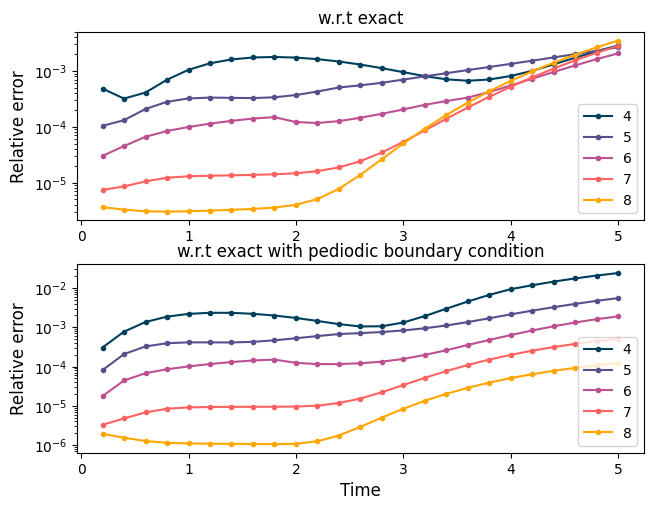

In [5]:
n_vec = np.arange(4,9)

M = 25
t = np.linspace(0,5,M+1)[1:]

fig, ax = plt.subplots(2)
fig.tight_layout()
color = ["#003f5c","#58508d","#bc5090","#ff6361","#ffa600"]

err_rel = np.zeros((M,len(n_vec),2))

for j,n in enumerate(n_vec):
    print(n)
    for i,T in enumerate(t):
        N = 2**n
        
        V = instance.solve("QC", n, sigma, T)
        exact = instance.solve("exact", n, sigma, T)
        exactp = instance.solve("exactp", n, sigma, T, NFourier=100)

        err_rel[i,j,0] = L2_rel(V,exact)
        err_rel[i,j,1] = L2_rel(V,exactp)

    ax[0].plot(t, err_rel[:,j,0],'.-', color=color[j])
    ax[1].plot(t, err_rel[:,j,1],'.-', color=color[j])
ax[1].set_xlabel('Time',fontsize=fontsize)
for i in range(2):
    ax[i].legend(n_vec)
    ax[i].set_ylabel('Relative error',fontsize=fontsize)
    ax[i].set_yscale('log')
ax[0].set_title("w.r.t exact")
ax[1].set_title("w.r.t exact with pediodic boundary condition")
plt.show()

### Optimisation

In [6]:
n_vec = np.arange(2,10)
Ncnots = np.zeros((2,len(n_vec)))
depth = np.zeros((2,len(n_vec)))

for i,n in enumerate(n_vec):
    print(n)
    N = 2**n
    
    instance.solve("None", n, sigma, T)
    # c_compile = qml.compile(instance.Circuit)
    c_compile_node = qml.QNode(instance.Circuit, instance.dev)
    coef_H = instance.get_coef_H(T)
    coef_A = instance.get_coef_A(T)
    Ncnots[0,i] = Ngates(c_compile_node,[coef_H, coef_A, n, N//2,N//2, False])
    Ncnots[1,i] = Ngates(c_compile_node,[coef_H, coef_A, n, N//2,N//2, True])
    
    depth[0,i] = qml.specs(c_compile_node)(coef_H, coef_A, n, N//2,N//2, False)["resources"].depth
    depth[1,i] = qml.specs(c_compile_node)(coef_H, coef_A, n, N//2,N//2, True)["resources"].depth
    

2
3
4
5
6
7
8
9


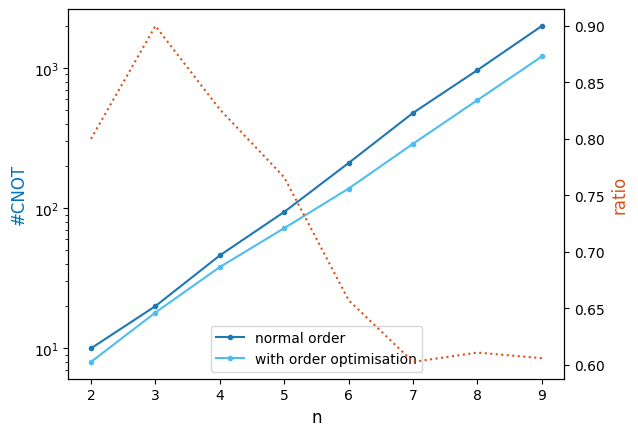

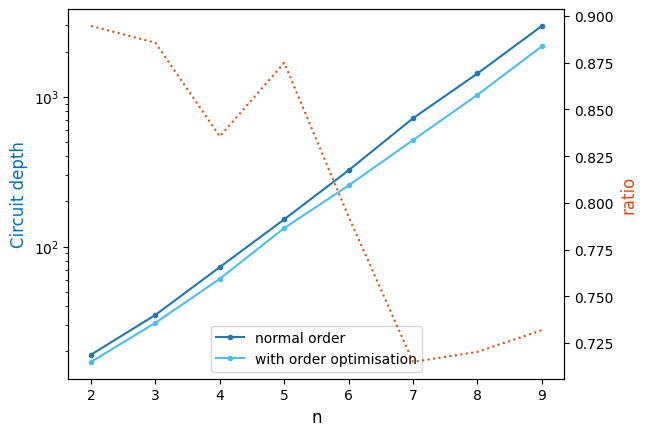

In [7]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(n_vec, Ncnots[0,:],'.-')
ax1.plot(n_vec, Ncnots[1,:],'.-', color=[0.3010, 0.7450, 0.9330])
ax2.plot(n_vec, Ncnots[1,:]/Ncnots[0,:], ':', color=[0.8500, 0.3250, 0.0980])
ax1.set_yscale('log')
ax1.set_ylabel('#CNOT', color=[0, 0.4470, 0.7410],fontsize=fontsize)
ax2.set_ylabel('ratio', color=[0.8500, 0.3250, 0.0980],fontsize=fontsize)
ax1.set_xlabel('n',fontsize=fontsize)
ax1.legend(["normal order","with order optimisation"],loc='lower center')
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(n_vec, depth[0,:],'.-')
ax1.plot(n_vec, depth[1,:],'.-', color=[0.3010, 0.7450, 0.9330])
ax2.plot(n_vec, depth[1,:]/depth[0,:], ':', color=[0.8500, 0.3250, 0.0980])
ax1.set_yscale('log')
ax2.set_ylabel('ratio', color=[0.8500, 0.3250, 0.0980], fontsize=fontsize)
ax1.set_ylabel('Circuit depth', color=[0, 0.4470, 0.7410], fontsize=fontsize)
ax1.set_xlabel('n', fontsize=fontsize)
ax1.legend(["normal order","with order optimisation"],loc='lower center')
plt.show()


### Approximations

Until now, all computations were done with perfect amplitude embedding, and considering all the $2^n$ rotations.\
But it is possible to use approximation to greatly reduce the size of the circuit.\
For instance, we can approximately load the function, using less CNOT gates. This can be done with the paramter $k$.\
This approximate loading consist of iteratively bisecting the domain. $k=n$ correspond to an exact amplitude embedding,
but good  approximation can eb achieve with smaller $k$.

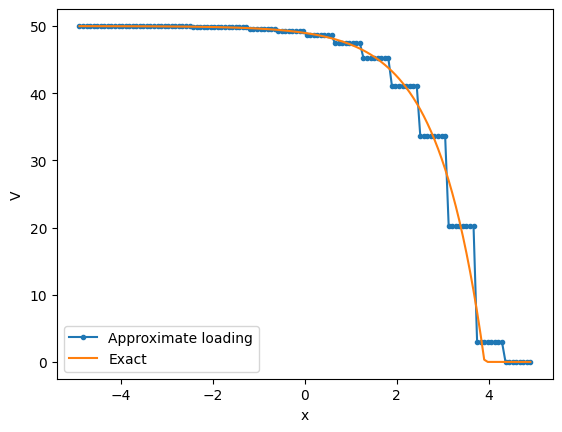

0.04119819946046717


In [8]:
n = 8
V = instance.solve("QC",n,sigma,T=0, order=False, k=5)
exact = instance.solve("exactp",n,sigma,T=0)
x = instance.x
plt.plot(x,V,'.-')
plt.plot(x,exact)
plt.ylabel("V")
plt.xlabel("x")
plt.legend(['Approximate loading', 'Exact'])
plt.show()
print(np.linalg.norm(V-exact)/np.linalg.norm(exact))

The number of terms taken into account in the Hamiltonian simulation can also be changed with the parameter $M$.\
For instance, we show here the solution using $M=[16,8]$, instead of the full $M=[128,128]$

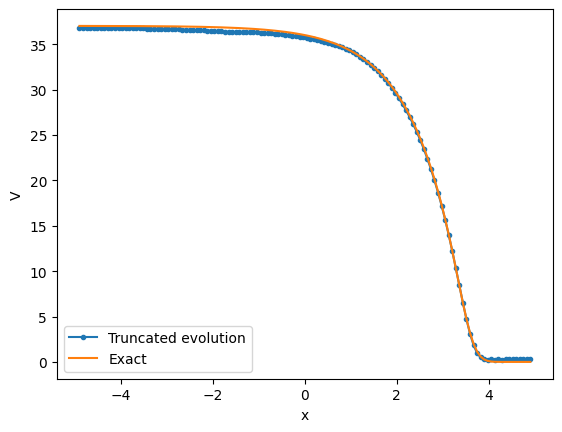

0.008481024344925845


In [9]:
n = 8
V = instance.solve("QC",n,sigma,T=1, order=False, M=[16, 8])
exact = instance.solve("exactp",n,sigma,T=1)
x = instance.x
plt.plot(x,V,'.-')
plt.plot(x,exact)
plt.ylabel("V")
plt.xlabel("x")
plt.legend(['Truncated evolution', 'Exact'])
plt.show()
print(np.linalg.norm(V-exact)/np.linalg.norm(exact))